In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA 


# Simulate an AR(2) process with alpha1 = 0.65 and alpha2=0.2

np.random.seed(1)
n_samples = int(5000)
a0 = 0
a1 = 0.65
a2 = 0.2
w = np.random.normal(size=n_samples) # Gaussian residuals
w_chi = np.random.chisquare(0.5, n_samples) # Chisquare residuals

# Chi with mean zero and variance 1
w_chi -= np.mean(w_chi)
w_chi /= np.std(w_chi)

print('Mean and Std deviation Normal distribution: ', ( round(np.mean(w), 2),  round(np.std(w), 2)))
print('Mean and Std deviation Chi distribution: ', (round(np.mean(w_chi), 2), round(np.std(w_chi), 2)))
y = np.zeros(n_samples)
y_chi = np.zeros(n_samples)

y[1] = y[0] = 0
y_chi[1] = y_chi[0] = 0

for t in range(2,n_samples):
    y[t] = a0 + a1*y[t-1] + a2*y[t-2]+ w[t] 
    y_chi[t] =  a0 + a1*y_chi[t-1] + a2*y_chi[t-2]+ w_chi[t] 



fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].plot(y)
plt.title('Normal distribution')
plt.hist(y)
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].plot(y_chi)
plt.title('Chi_square distribution')
plt.hist(y_chi)
plt.show()

Mean and Std deviation Normal distribution:  (0.02, 1.0)
Mean and Std deviation Chi distribution:  (-0.0, 1.0)


<Figure size 1500x600 with 2 Axes>

<Figure size 1500x600 with 2 Axes>

### Prediction T+1

In [2]:
# Select the time series (y, w) o (y_chi, w_chi)
target = y_chi
res = w_chi

In [3]:
# Estimate the AR(2) model
model = ARIMA(target, order = (2,0,0))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7093.098
Date:                Tue, 14 Mar 2023   AIC                          14194.197
Time:                        15:09:31   BIC                          14220.265
Sample:                             0   HQIC                         14203.333
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.147      0.008      0.994      -0.287       0.289
ar.L1          0.6221      0.016     38.998      0.000       0.591       0.653
ar.L2          0.2227      0.015     15.174      0.0

In [4]:
# 5 steps-ahead point predictions
y_pred = model_fit.get_forecast(steps = 5)

# Point predictions, prediction standard deviation and confidence intervals
y_pred_summary = y_pred.summary_frame()
y_pred.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,-0.702530,0.999560,-2.661631,1.256571
1,-0.635988,1.177214,-2.943286,1.671310
2,-0.551970,1.325651,-3.150199,2.046259
3,-0.484878,1.423160,-3.274220,2.304464
4,-0.424424,1.494996,-3.354563,2.505715


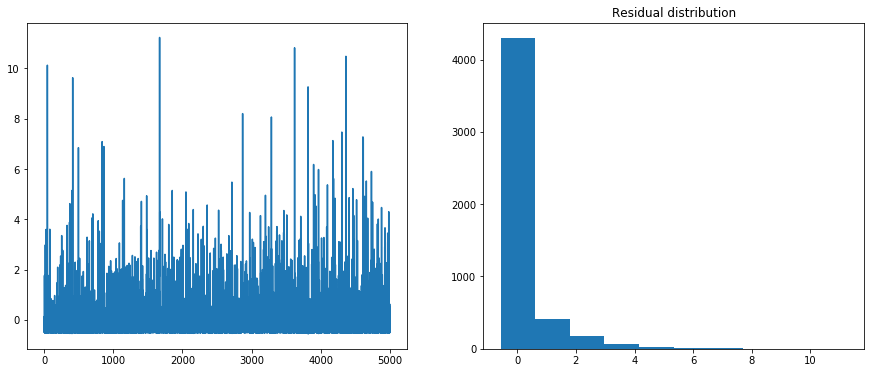

array([0.00116442, 0.62213774, 0.22273569, 0.99911925])

In [5]:
# Estimated parameters
const = model_fit.params[0]
ar1 = model_fit.params[1]
ar2 = model_fit.params[2]
residuos = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].plot(residuos)
plt.title('Residual distribution')
plt.hist(residuos)
plt.show()
# Estimated model fitted parameters
model_fit.params

# Bootstrap density funtions

### Prediction T+1

Confidence interval (under normality) : -2.6616667043152287 1.2566066519467607
Bootstrap confidence interval:  -1.2274696857368497 2.3552010070211526
Point prediction under AR(2):  -0.7
Mean of the bootstrap distribution:  -0.7068


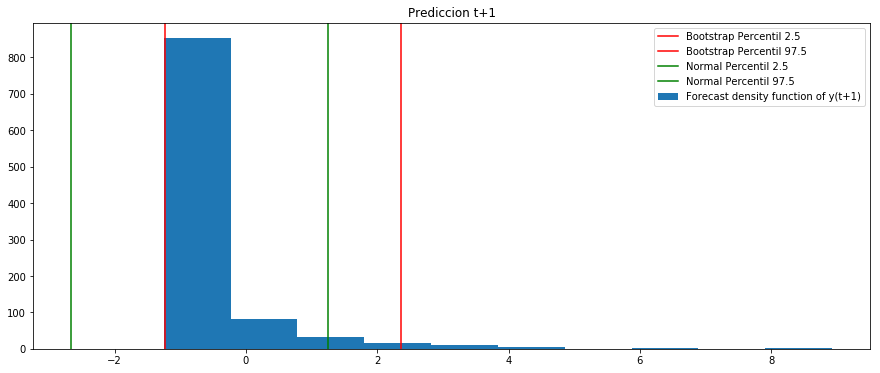

In [6]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True) # bootstrap with replacement
# pred_t1 = const + ar1 * target[-1] + ar2 * target[-2] + residuos_ar
pred_t1 = ar1 * target[-1] + ar2 * target[-2] + residuos_ar
# Prediction confidence intervals under normality
low_ci = y_pred_summary.iloc[0,0] - 1.96 * y_pred_summary.iloc[0, 1]
upper_ci = y_pred_summary.iloc[0,0] + 1.96 * y_pred_summary.iloc[0, 1]

print('Confidence interval (under normality) :', low_ci, upper_ci)
print('Bootstrap confidence interval: ', np.percentile(pred_t1, 2.5), np.percentile(pred_t1, 97.5))

print('Point prediction under AR(2): ', round(y_pred_summary.iloc[0,0],2))
print('Mean of the bootstrap distribution: ', round(np.mean(pred_t1),4))

plt.figure(figsize = (15,6))
plt.hist(pred_t1, label = 'Forecast density function of y(t+1)')
plt.axvline(x = np.percentile(pred_t1, 2.5), color = 'red', label = 'Bootstrap Percentil 2.5')
plt.axvline(x = np.percentile(pred_t1, 97.5), color = 'red', label = 'Bootstrap Percentil 97.5')
plt.axvline(x = low_ci, color = 'green', label = 'Normal Percentil 2.5')
plt.axvline(x = upper_ci, color = 'green', label = 'Normal Percentil 97.5')
plt.title('Prediccion t+1')

plt.legend()
plt.show()

### Prediction T+2

Confidence interval (under normality): -2.9433281028541307 1.6713523023222425
Bootstrap confidence interval:  -1.4776770613950438 2.2671481489397887
Point prediction under AR(2):  -0.64
Mean of the bootstrap distribution:  -0.6801


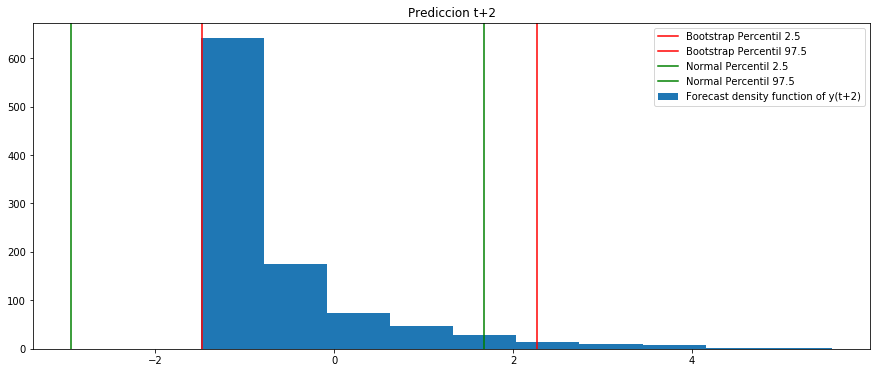

In [7]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True) # bootstrap with replacement
#pred_t2 = const + ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_ar)
pred_t2 = ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_ar)
low_ci = y_pred_summary.iloc[1,0] - 1.96 * y_pred_summary.iloc[1, 1]
upper_ci = y_pred_summary.iloc[1,0] + 1.96 * y_pred_summary.iloc[1, 1]

print('Confidence interval (under normality):', low_ci, upper_ci)
print('Bootstrap confidence interval: ', np.percentile(pred_t2, 2.5), np.percentile(pred_t2, 97.5))

print('Point prediction under AR(2): ', round(y_pred_summary.iloc[1,0],2))
print('Mean of the bootstrap distribution: ', round(np.mean(pred_t2),4))

plt.figure(figsize = (15,6))
plt.hist(pred_t2, label = 'Forecast density function of y(t+2)')
plt.axvline(x = np.percentile(pred_t2, 2.5), color = 'red', label = 'Bootstrap Percentil 2.5')
plt.axvline(x = np.percentile(pred_t2, 97.5), color = 'red', label = 'Bootstrap Percentil 97.5')
plt.axvline(x = low_ci, color = 'green', label = 'Normal Percentil 2.5')
plt.axvline(x = upper_ci, color = 'green', label = 'Normal Percentil 97.5')
plt.title('Prediccion t+2')
plt.legend()
plt.show()

### Prediction t+3

Confidence interval (under normality): -3.150246476000005 2.046306578843126
Bootstrap confidence interval:   -1.6923625449631916 2.987634323788812
Point prediction under AR(2):  -0.55
Mean of the bootstrap distribution:  -0.567


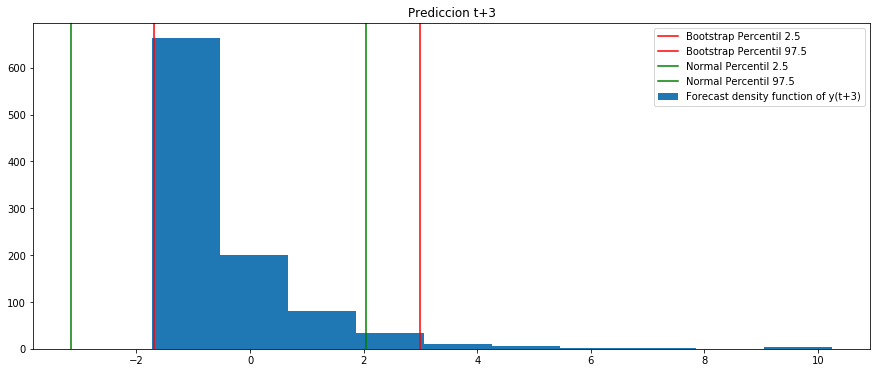

In [8]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True) # bootstrap with replacement
#pred_t3 = const + ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_ar)
pred_t3 = ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_ar)

low_ci = y_pred_summary.iloc[2,0] - 1.96 * y_pred_summary.iloc[2, 1]
upper_ci = y_pred_summary.iloc[2,0] + 1.96 * y_pred_summary.iloc[2, 1]
print('Confidence interval (under normality):', low_ci, upper_ci)
print('Bootstrap confidence interval:  ', np.percentile(pred_t3, 2.5), np.percentile(pred_t3, 97.5))

print('Point prediction under AR(2): ', round(y_pred_summary.iloc[2,0],2))
print('Mean of the bootstrap distribution: ', round(np.mean(pred_t3),4))

plt.figure(figsize = (15,6))
plt.hist(pred_t3, label = 'Forecast density function of y(t+3)')
plt.axvline(x = np.percentile(pred_t3, 2.5), color = 'red', label = 'Bootstrap Percentil 2.5')
plt.axvline(x = np.percentile(pred_t3, 97.5), color = 'red', label = 'Bootstrap Percentil 97.5')
plt.axvline(x = low_ci, color = 'green', label = 'Normal Percentil 2.5')
plt.axvline(x = upper_ci, color = 'green', label = 'Normal Percentil 97.5')
plt.title('Prediccion t+3')
plt.legend()
plt.show()

# Comparison of density functions for t+1

- Estimated residuals AR(2)
- Real residuals

Confidence intervals with real residuals:  -1.2289131216368219 1.7966642507108455
Confidence intervals with estimated residuals:  -1.2113212393210004 2.3880028547659244


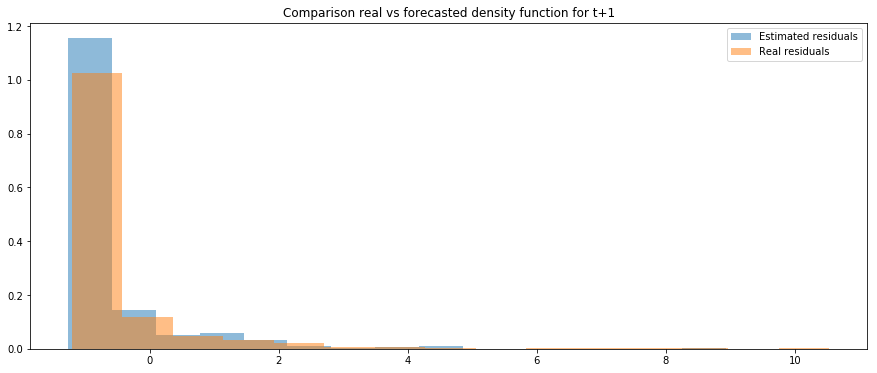

In [9]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True)
residuos_or = pd.Series(res).sample(1000, replace = True)
#pred_t1_ar = const + ar1 * target[-1] + ar2 * target[-2] + residuos_ar
#pred_t1_or = const + ar1 * target[-1] + ar2 * target[-2] + residuos_or 
pred_t1_ar = ar1 * target[-1] + ar2 * target[-2] + residuos_ar
pred_t1_or = ar1 * target[-1] + ar2 * target[-2] + residuos_or 
print('Confidence intervals with real residuals: ',
      np.percentile(pred_t1_ar, 2.5), np.percentile(pred_t1_ar, 97.5))

print('Confidence intervals with estimated residuals: ',
      np.percentile(pred_t1_or, 2.5), np.percentile(pred_t1_or, 97.5))

kwargs = dict(alpha=0.5, bins=15, density=True, stacked=True)

plt.figure(figsize = (15,6))
plt.hist(pred_t1_ar, **kwargs, label = 'Estimated residuals')
plt.hist(pred_t1_or, **kwargs, label = 'Real residuals')
plt.title('Comparison real vs forecasted density function for t+1')
plt.legend()
plt.show()

Confidence intervals with real residuals:  -1.4753852042542566 2.12888914756892
Confidence intervals with estimated residuals:  -1.4670711218030195 2.8479416173262657


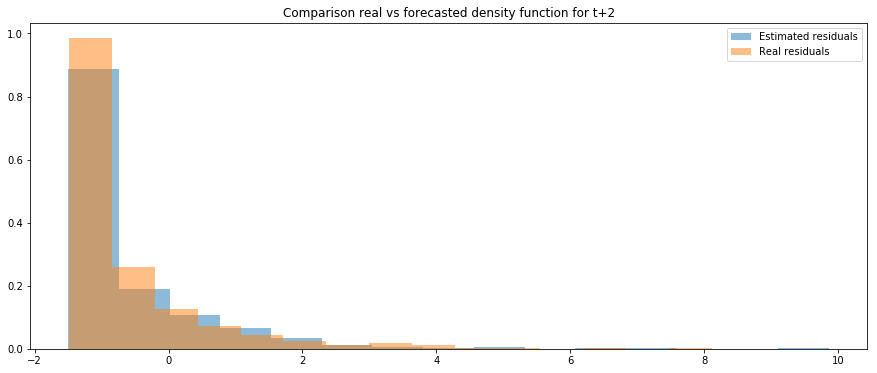

In [10]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True)
residuos_or = pd.Series(res).sample(1000, replace = True)
#pred_t1_ar = const + ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_ar)
#pred_t1_or = const + ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_or)
pred_t1_ar = ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_ar)
pred_t1_or = ar1 * np.array(pred_t1) + ar2 * target[-1] + np.array(residuos_or)
print('Confidence intervals with real residuals: ',
      np.percentile(pred_t1_ar, 2.5), np.percentile(pred_t1_ar, 97.5))

print('Confidence intervals with estimated residuals: ',
      np.percentile(pred_t1_or, 2.5), np.percentile(pred_t1_or, 97.5))

plt.figure(figsize = (15,6))
plt.hist(pred_t1_ar, **kwargs, label = 'Estimated residuals')
plt.hist(pred_t1_or, **kwargs, label = 'Real residuals')
plt.title('Comparison real vs forecasted density function for t+2')
plt.legend()
plt.show()

Confidence intervals with real residuals:  -1.690667812241996 2.5641573935959254
Confidence intervals with estimated residuals:  -1.6846468824132066 2.537650388164769


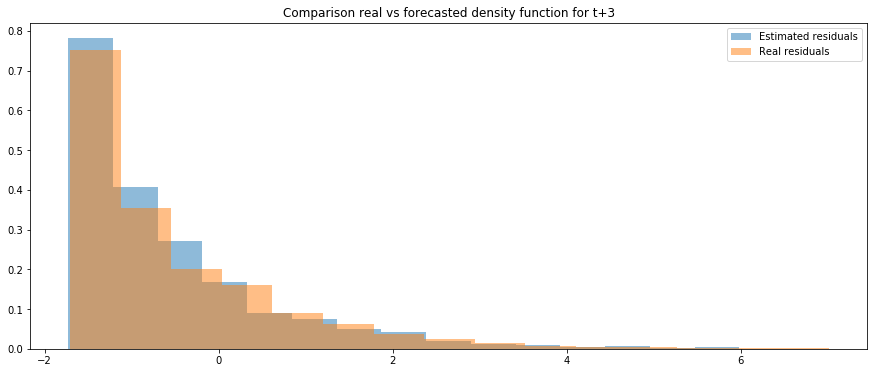

In [11]:
residuos_ar = pd.Series(residuos).sample(1000, replace = True)
residuos_or = pd.Series(res).sample(1000, replace = True)
#pred_t1_ar = const + ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_ar)
#pred_t1_or = const + ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_or)
pred_t1_ar = ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_ar)
pred_t1_or = ar1 * np.array(pred_t2) + ar2 * np.array(pred_t1) + np.array(residuos_or)
print('Confidence intervals with real residuals: ',
      np.percentile(pred_t1_ar, 2.5), np.percentile(pred_t1_ar, 97.5))

print('Confidence intervals with estimated residuals: ',
      np.percentile(pred_t1_or, 2.5), np.percentile(pred_t1_or, 97.5))

plt.figure(figsize = (15,6))
plt.hist(pred_t1_ar, **kwargs, label = 'Estimated residuals')
plt.hist(pred_t1_or, **kwargs, label = 'Real residuals')
plt.title('Comparison real vs forecasted density function for t+3')
plt.legend()
plt.show()